In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import eigh
from scipy.interpolate import BSpline
from sklearn.decomposition import PCA
from scipy.stats import norm
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv("data_clean.csv").drop(columns=["Unnamed: 0"]).set_index("day_tick")

We exclude the first day of data since it doesn't have values for the first ticks

In [3]:
data = data[data.day != 1]

## Step 1. Set up our data 

Set the first log return of a day equal to NaN

In [4]:
data['log_returns'] = data.groupby('day')['log_returns'].transform(lambda x: x.mask(x.index == x.index.min(), 0))

Now we can compute the intraday cumulative log returns

In [5]:
data['cum_log_returns'] = data.groupby('day')['log_returns'].cumsum()

Text(0, 0.5, 'Intraday Log returns')

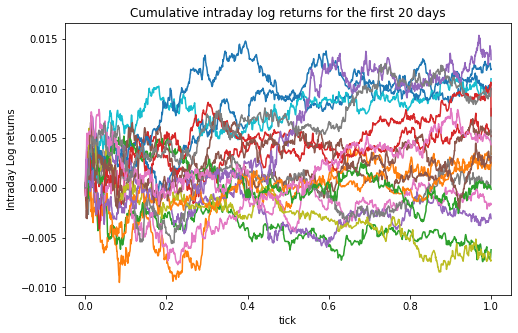

In [6]:
plt.figure(figsize=(8,5))
data[data.day<20].set_index("tick").groupby("day")["cum_log_returns"].plot()
plt.title("Cumulative intraday log returns for the first 20 days")
plt.ylabel("Intraday Log returns")


In [7]:
data = data.reset_index()

## Step 2. Setup FDA 

In [8]:
# Pivot the data to have days as rows and ticks as columns
data_reset = data.reset_index()
data_pivot = data_reset.pivot(index='day', columns='tick', values='cum_log_returns')

# Handle missing values by interpolation
data_pivot = data_pivot.interpolate(axis=1)

# Extract the values (observations) and the time points (ticks)
Y = data_pivot.values
ticks = data_pivot.columns.values

Define a function to perform FPCA using B-spline basis functions

In [ ]:
def perform_fpca_bspline(Y, ticks, n_basis=20, p_components=5, degree=3):
    
    n_samples, n_ticks = Y.shape
    domain_range = (ticks[0], ticks[-1])
    
    # Construct B-spline Basis Functions
    # Create a knot vector with appropriate knots
    knots = np.linspace(domain_range[0], domain_range[1], n_basis - degree + 1)
    # Add degree many knots at the boundaries
    knots = np.concatenate((
        np.repeat(domain_range[0], degree),
        knots,
        np.repeat(domain_range[1], degree)
    ))
    # Number of basis functions is len(knots) - (degree + 1)
    n_bases = len(knots) - (degree + 1)
    
    # Create B-spline basis functions
    basis_functions = []
    for i in range(n_bases):
        coef = np.zeros(n_bases)
        coef[i] = 1
        spline = BSpline(t=knots, c=coef, k=degree, extrapolate=False)
        basis_functions.append(spline)
    
    # Evaluate basis functions at time points (ticks) to construct matrix P
    P = np.array([basis(ticks) for basis in basis_functions]).T
    
    # Handle any NaN values in P (can occur at boundaries)
    P = np.nan_to_num(P)
    
    # Project Data onto Basis Functions to Obtain Coefficients A
    # Solve the least squares problem Y = A * P^T
    # Transpose Y to match dimensions with P
    A = np.linalg.lstsq(P, Y.T, rcond=None)[0].T
    
    # Estimate the Mean Function μ(t)
    # Estimate μ(t) by averaging the coefficients across samples
    mean_coef = np.mean(A, axis=0)
    
    # Define mean function μ(t) using the basis functions
    def mean_function(t):
        basis_eval = np.array([basis(t) for basis in basis_functions])
        return np.dot(mean_coef, basis_eval)
    
    # Center the Coefficients
    A_centered = A - mean_coef
    
    # Estimate the Covariance Matrix of Coefficients Σ_A
    Sigma_A = np.cov(A_centered, rowvar=False)
    
    # Perform Eigen Decomposition of Σ_A
    eigenvalues_full, eigenvectors_full = eigh(Sigma_A)

    # Sort eigenvalues and eigenvectors in descending order
    idx = eigenvalues_full.argsort()[::-1]  # To get the indexes of the sorting, instead of actually sorting
    eigenvalues_full = eigenvalues_full[idx]
    eigenvectors_full = eigenvectors_full[:, idx]

    # Calculate the total variance using all eigenvalues
    total_variance = np.sum(eigenvalues_full)

    # Keep only the first p_components
    eigenvalues = eigenvalues_full[:p_components]
    eigenvectors = eigenvectors_full[:, :p_components]
    
    # Construct Eigenfunctions ψ_k(t)
    # Each eigenfunction is a linear combination of basis functions 
    eigenfunctions = []
    for k in range(p_components):
        coef = eigenvectors[:, k]
        # Create the eigenfunction as a callable function
        def eigenfunction(t, coef=coef):
            basis_eval = np.array([basis(t) for basis in basis_functions])
            return np.dot(coef, basis_eval)
        eigenfunctions.append(eigenfunction)
    
    # Compute the Scores ξ_{ik}
    # Scores are projections of centered coefficients in the eigenvectors
    scores = np.dot(A_centered, eigenvectors)
    
    # Variance Decomposition
    explained_variance_ratio = eigenvalues / total_variance
    
    return {
        'mean_function': mean_function,
        'eigenfunctions': eigenfunctions,
        'scores': scores,
        'explained_variance': eigenvalues,
        'explained_variance_ratio': explained_variance_ratio,
        'basis_functions': basis_functions,
        'coef_matrix': A,
        'eigenvectors': eigenvectors
    }

In [10]:
# Perform FPCA using B-spline basis functions
results = perform_fpca_bspline(Y, ticks, n_basis=20, p_components=10, degree=3)

# Extract results
mean_function = results['mean_function']
eigenfunctions = results['eigenfunctions']
scores = results['scores']
eigenvalues = results['explained_variance']
explained_variance_ratio = results['explained_variance_ratio']
basis_functions = results['basis_functions']
A = results['coef_matrix']
eigenvectors = results['eigenvectors']

## Step 3. Analyze FDA Results

### 1. Mean fuction and eigenfunctions

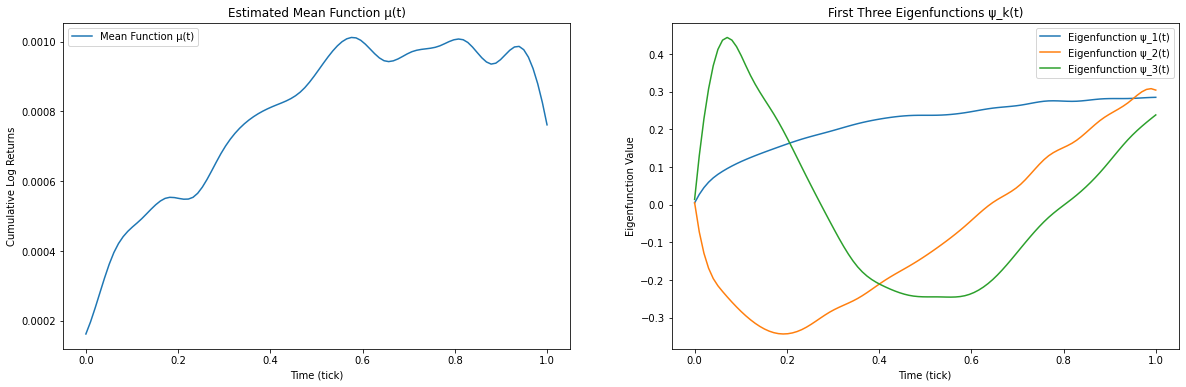

In [11]:
# Plot the mean function μ(t)
t_plot = np.linspace(ticks[0], ticks[-1], 100)
mu_t_plot = np.array([mean_function(t) for t in t_plot])

_, axs = plt.subplots(1,2,figsize=(20, 6))
axs[0].plot(t_plot, mu_t_plot, label='Mean Function μ(t)')
axs[0].set_title('Estimated Mean Function μ(t)')
axs[0].set_xlabel('Time (tick)')
axs[0].set_ylabel('Cumulative Log Returns')
axs[0].legend()

# Plot the first few eigenfunctions ψ_k(t)
num_eigenfunctions_to_plot = 3
for k in range(num_eigenfunctions_to_plot):
    psi_k_t = np.array([eigenfunctions[k](t) for t in t_plot])
    axs[1].plot(t_plot, psi_k_t, label=f'Eigenfunction ψ_{k+1}(t)')
axs[1].set_title('First Three Eigenfunctions ψ_k(t)')
axs[1].set_xlabel('Time (tick)')
axs[1].set_ylabel('Eigenfunction Value')
axs[1].legend()
plt.show()

We observe that the ith eigenfunction has i-1 peaks, which is something that comes from ortogonality and the choice of our basis.

1. **Mean Function $\mu(t)$**: Shows a general upward trend in cumulative log returns, suggesting an overall positive drift in the stock price.

2. **First Eigenfunction $\psi_1(t)$**: Primarily aligns with the mean trend, indicating that the main variation is consistent with the upward movement, possibly reflecting market momentum.

3. **Second Eigenfunction $\psi_2(t)$**: Exhibits oscillations, capturing cyclical patterns like intraday volatility or short-term reversals common in high-frequency data.

4. **Third Eigenfunction $\psi_3(t)$**: Displays higher-frequency fluctuations, likely representing noise or transient effects from market microstructure and high-frequency trading activity.



Let's se how well we have captured the tendency of some days (using the 20 B-Splines and our 3 first eigenvectors)

In [12]:
# Precompute the basis matrix:
basis_matrix = np.array([basis(ticks) for basis in basis_functions])

# Reconstruct the data using the basis functions and mean function
Y_reconstructed = np.dot(A, basis_matrix)

In [13]:
# Get the first 3 eigenvectors
eigenvectors_p = eigenvectors[:, :3]

# Project centered A onto the first 3 eigenvectors to get scores_p
scores_p = np.dot(A - A.mean(axis=0), eigenvectors_p)

# Reconstruct coefficients using the scores and eigenvectors
A_reconstructed_eigen = np.dot(scores_p, eigenvectors_p.T) + A.mean(axis=0)

# Reconstruct the data Y using the reconstructed A and basis functions
Y_reconstructed_eigen = np.dot(A_reconstructed_eigen, basis_matrix)


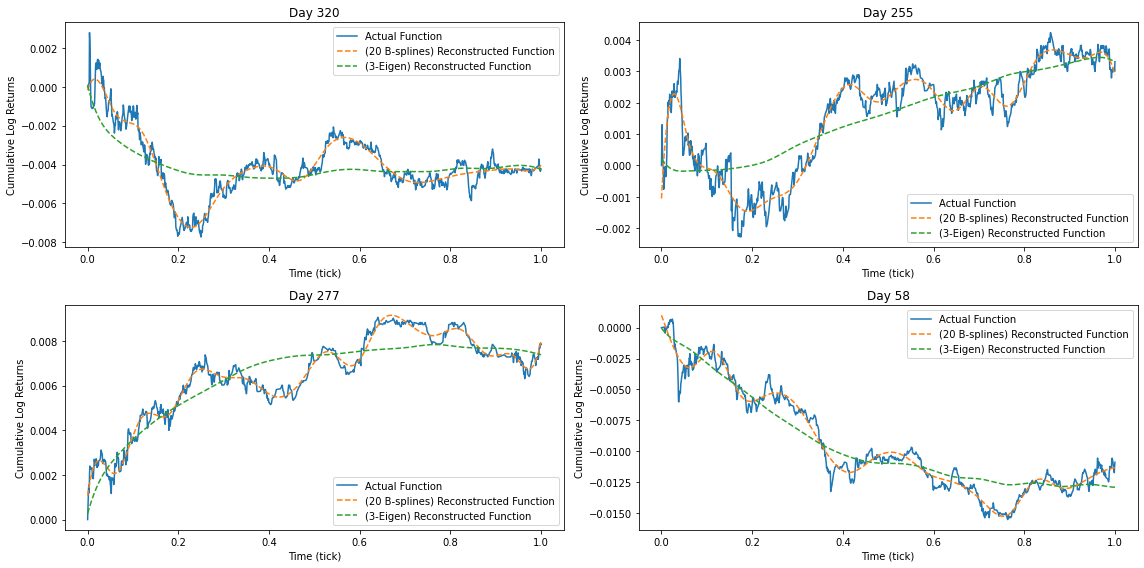

In [14]:
# Choose 4 random days
np.random.seed(43)
days = np.random.choice(list(range(Y_reconstructed.shape[0])),4)

rows = 2
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
# fig.suptitle('Actual vs. Reconstructed Functions for some days', fontsize=16)
axes = axes.flatten()

for i in range(rows*cols):
    ax = axes[i]
    ax.plot(ticks, data_pivot.iloc[days[i]], label='Actual Function')
    ax.plot(ticks, Y_reconstructed[days[i],:], label='(20 B-splines) Reconstructed Function', linestyle='--')
    ax.plot(ticks, Y_reconstructed_eigen[days[i],:], label='(3-Eigen) Reconstructed Function', linestyle='--')
    ax.set_title(f'Day {days[i]}')
    ax.set_xlabel('Time (tick)')
    ax.set_ylabel('Cumulative Log Returns')
    ax.legend()


plt.tight_layout()
plt.savefig("Trajectories.png")


### 2. Scores $ξ_{ik}$

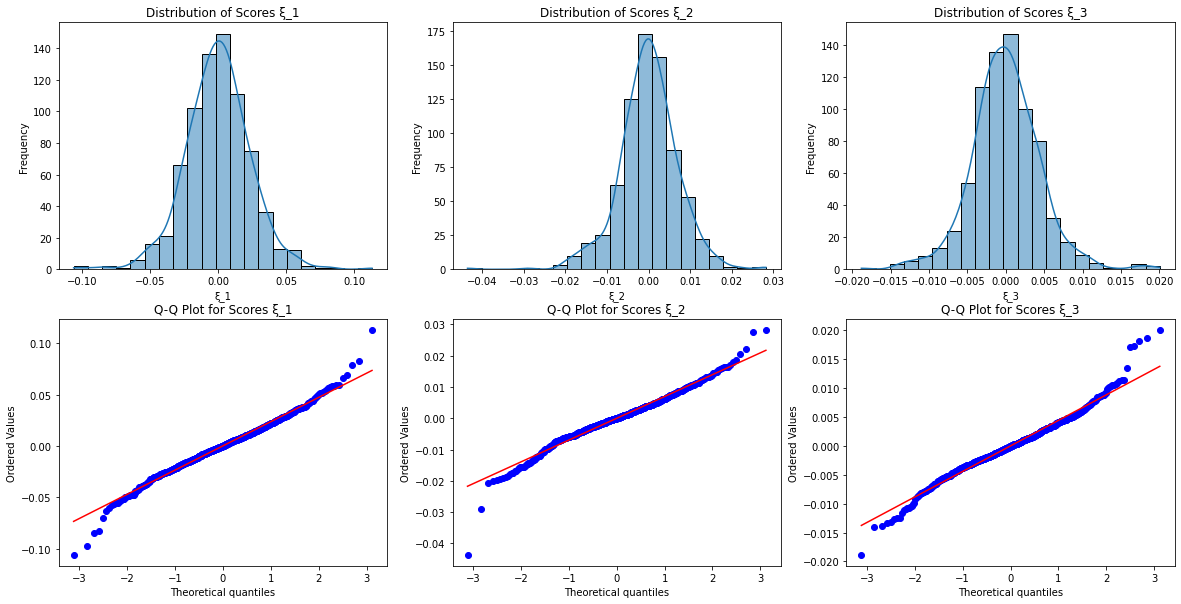

In [15]:
_, axs = plt.subplots(2,3,figsize=(20, 10))
# Analyze the distribution of scores ξ_{ik}
for k in range(num_eigenfunctions_to_plot):
    sns.histplot(scores[:, k], kde=True, ax=axs[0,k], bins=21)
    axs[0,k].set_title(f'Distribution of Scores ξ_{k+1}')
    axs[0,k].set_xlabel(f'ξ_{k+1}')
    axs[0,k].set_ylabel('Frequency')

# Check normality of scores using Q-Q plot
import scipy.stats as stats
for k in range(num_eigenfunctions_to_plot):
    stats.probplot(scores[:, k], dist="norm", plot=axs[1,k])
    axs[1,k].set_title(f'Q-Q Plot for Scores ξ_{k+1}')

plt.savefig("Scores.png")

The Q-Q plots show that the data closely aligns with a normal distribution, especially in the central region, with some deviations in the tails indicating slight departures from perfect normality, possibly due to heavier tails.

Analyze the autocorrelation function (ACF) of the scores to determine if they can be considered white noise.

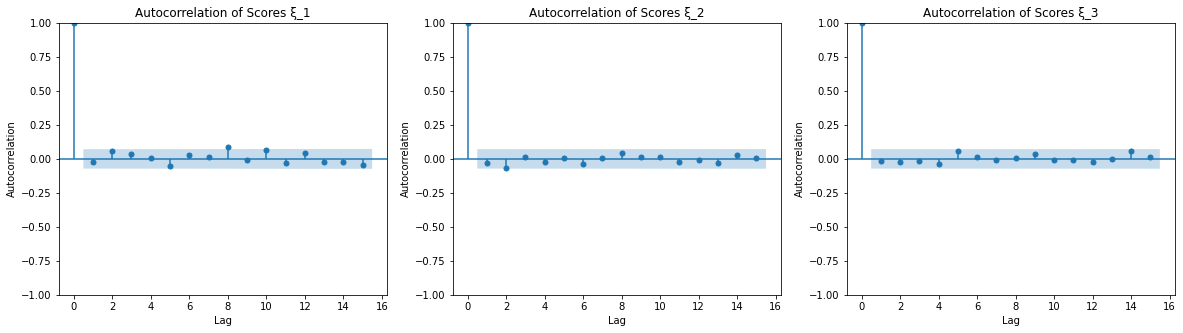

In [16]:
_, axs = plt.subplots(1,3,figsize=(20,5))
for k in range(num_eigenfunctions_to_plot):
    plot_acf(scores[:, k], lags=15, ax=axs[k])
    axs[k].set_title(f'Autocorrelation of Scores ξ_{k+1}')
    axs[k].set_xlabel('Lag')
    axs[k].set_ylabel('Autocorrelation')
plt.savefig("ACF Scores.png")

We observe that our scores are similar to white-noise, which implies that we are not going to be sucessful in fitting a time series model such as AR to these values later. Our best guess for each Score is just the sample mean.

In [17]:
lags = np.arange(1,10,1)

for k in range(scores.shape[1]):
    component_scores = scores[:, k]
    
    # Perform Ljung-Box test
    lb_test = acorr_ljungbox(component_scores, lags=lags, return_df=True)
    
    # Extract p-values for the specified lags
    p_values = lb_test['lb_pvalue'].values
    
    print(f"Ljung-Box Test for Principal Component {k+1}:")
    for lag, p_val in zip(lags, p_values):
        if p_val > 0.05:
            result = "Fail to reject H0 (No autocorrelation)"
        else:
            result = "Reject H0 (Autocorrelation detected)"
        print(f"  - Lag {lag}: p-value = {p_val:.4f} -> {result}")
    print('-' * 60)

Ljung-Box Test for Principal Component 1:
  - Lag 1: p-value = 0.5117 -> Fail to reject H0 (No autocorrelation)
  - Lag 2: p-value = 0.2347 -> Fail to reject H0 (No autocorrelation)
  - Lag 3: p-value = 0.2646 -> Fail to reject H0 (No autocorrelation)
  - Lag 4: p-value = 0.4086 -> Fail to reject H0 (No autocorrelation)
  - Lag 5: p-value = 0.3172 -> Fail to reject H0 (No autocorrelation)
  - Lag 6: p-value = 0.3567 -> Fail to reject H0 (No autocorrelation)
  - Lag 7: p-value = 0.4486 -> Fail to reject H0 (No autocorrelation)
  - Lag 8: p-value = 0.1330 -> Fail to reject H0 (No autocorrelation)
  - Lag 9: p-value = 0.1870 -> Fail to reject H0 (No autocorrelation)
------------------------------------------------------------
Ljung-Box Test for Principal Component 2:
  - Lag 1: p-value = 0.4437 -> Fail to reject H0 (No autocorrelation)
  - Lag 2: p-value = 0.1622 -> Fail to reject H0 (No autocorrelation)
  - Lag 3: p-value = 0.2861 -> Fail to reject H0 (No autocorrelation)
  - Lag 4: p-va

### 3. Residuals

Compute residuals and estimate the noise variance (i.e. reconstruction error)

In [18]:
# Compute residuals (from the reconstruction using the first 3 eigenfunctions)
residuals = Y - Y_reconstructed_eigen

# Estimate noise variance η²
eta_squared = np.var(residuals)
print(f"Estimated Noise Variance η²: {eta_squared}")

Estimated Noise Variance η²: 1.6490744205454134e-06


Noise Variance (η²): Represents the variance of the residuals not explained by the model.
A smaller η² indicates a better fit of the model to the data.

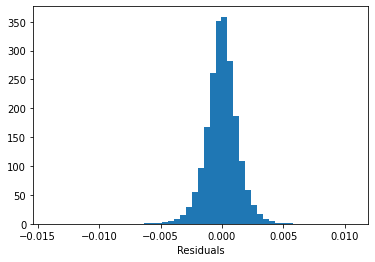

In [19]:
plt.hist(residuals.flatten(),bins=51,density=True)
plt.xlabel("Residuals")
plt.show()

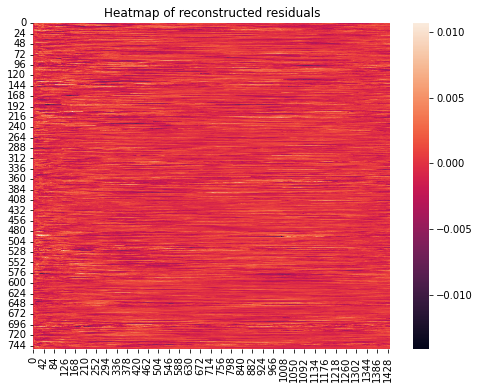

In [20]:
plt.figure(figsize=(8,6))
plt.xlabel("Tick")
plt.ylabel("Day")
plt.title("Heatmap of reconstructed residuals")
sns.heatmap(residuals)
plt.show()

### 4. Fit Quality as a Function of 𝑝

We'll plot the cumulative explained variance to assess how the number of principal components 𝑝 affects the fit quality.

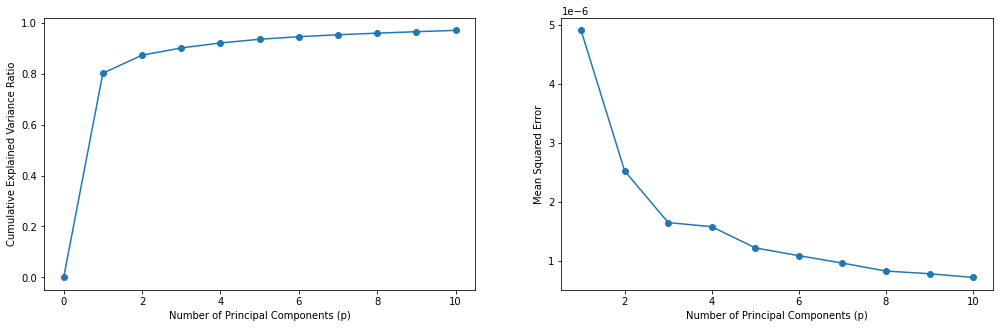

In [21]:
# Plot cumulative explained variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
_, axis = plt.subplots(1,2,figsize=(17, 5))
axis[0].plot(range(0, len(explained_variance_ratio) + 1), np.concatenate([[0],cumulative_variance_ratio]), marker='o')
# axis[0].set_title('Cumulative Explained Variance')
axis[0].set_xlabel('Number of Principal Components (p)')
axis[0].set_ylabel('Cumulative Explained Variance Ratio')

# Set the maximum number of components to use in reconstruction
max_components = eigenvectors.shape[1]
reconstruction_errors = []

# Calculate the mean of A for centering
A_mean = np.mean(A, axis=0)

# Loop through each number of components from 1 up to max_components
for p in range(1, max_components + 1):
    # Use the first p eigenvectors (columns of eigenvectors)
    eigenvectors_p = eigenvectors[:, :p]

    # Project centered A onto the first p eigenvectors to get scores_p
    scores_p = np.dot(A - A_mean, eigenvectors_p)

    # Reconstruct coefficients using the scores and eigenvectors
    A_reconstructed = np.dot(scores_p, eigenvectors_p.T) + A_mean

    # Reconstruct the data Y using the reconstructed A and basis functions
    # Y_reconstructed = A_reconstructed.dot(basis_matrix)
    Y_reconstructed = np.dot(A_reconstructed, basis_matrix)

    # Compute reconstruction error (Mean Squared Error)
    mse = mean_squared_error(Y, Y_reconstructed)
    reconstruction_errors.append(mse)

# Plot reconstruction error vs. number of components
axis[1].plot(range(1, max_components + 1), reconstruction_errors, marker='o')
# axis[1].set_title('Reconstruction Error vs. Number of Principal Components')
axis[1].set_xlabel('Number of Principal Components (p)')
axis[1].set_ylabel('Mean Squared Error')

plt.savefig("Reconstruction error.png")